In [1]:
'''A script to run UQ for a pipe using PCN.

Parameters
----------

expan_coef: int
size of friction coefficient vector

uni_prior_down: float * expan_coef
lower bound for the uniform prior

uni_prior_up: float * expan_coef
upper bound for the uniform prior

initial_point_mcmc: float * expan_coef
initial point in the MCMC sampler

c_sound: float
sound speed

t_final: float
final time

x_l: float
left boundary of the domain

x_r: float
right boundary of the domain

dx: float
mesh size

boundary_eps: float
a number for computing pressure drop at both ends of the pipe

pipe_true: SemiLinSystem
an object that represents and contains attributes of the true pipe

pipe: SemiLinSystem 
an object that represents and contains attributes
of a pipe used during MCMC for sampling

'''

from UQuant.pcn import PCN
from UQuant.SemilinearSystem import SemiLinSystem

from numpy.random import normal
from numpy import pi, exp, dot, sqrt
from numpy import empty

from scipy.stats import norm as scipy_norm
from scipy.special import erfinv

from math  import isnan

# build a pipe

## physical settings
c_sound = 1.0
t_final = 5.0
x_l, x_r = [0.0, 1.0]
dx = 0.005
boundary_eps = 0.05

## true friction coefficient
true_friction = [0.185938, -0.0519335, 0., 0., -0.0696583, 0.0336323, 0., 0., \
                 0.0348292, -0.0121076, 0., 0., -0.00773981, 0.00105987, 0., 0., 0., \
                 -0.000641154, 0., 0., -0.00278633, 0.00250158, 0., 0., 0.00386991, \
                 -0.00179107, 0., 0., -0.0014216, 0.000230816, 0., 0., 0., \
                 -0.000179701, 0., 0., -0.000859979, 0.000838478, 0., 0., 0.00139317]

true_expan_coef = len(true_friction)

time_ins = 20

In [2]:
## construct and run the true pipe
pipe_true = SemiLinSystem(c_sound, t_final, x_l, x_r, dx, true_expan_coef, boundary_eps)
pipe_true.run(true_friction)

std_noise = 0.05
mean_noise = 0.0

y_obs = normal(mean_noise, std_noise, time_ins) + \
        pipe_true.get_presure_drop(time_instance=time_ins, inplace=False)

# construct a pipe for computation
## stochastic settings
uni_prior_down = [0.0, -0.025, -0.025, -0.025, -0.025, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01]
uni_prior_up   = [0.45, 0.025, 0.025, 0.025, 0.025, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]


initial_point_mcmc = [0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

expan_coef = len(initial_point_mcmc)

pipe = SemiLinSystem(c_sound, t_final, x_l, x_r, dx, expan_coef, boundary_eps)

Address of the pipe in the memory from python:  0x2ef73c0
Address of the pipe in the memory from python:  0x2f16d10


In [3]:
def normal_to_uniform(x):
    """normal_to_uniform converts a given vector x with normal
    distribution (0, I) into a vector with uniform distribution.

    x: [float] * len(x)

    returns: [float] * len(x)
    """

    length = len(x)
    
    output = scipy_norm.cdf(x)
    
    for i in range(length):
        limit = (uni_prior_up[i] - uni_prior_down[i])
        output[i] = output[i]*limit + uni_prior_down[i]

    return output

def uniform_to_normal(x):
    """converts a uniform random variable to a normal distribution
    """
    import copy
    
    length = len(x)

    output = copy.deepcopy(x)

    for i in range(length):
        limit = (uni_prior_up[i] - uni_prior_down[i])
        tmp   = (output[i] - uni_prior_down[i]) / limit
        output[i] = sqrt(2.0) * erfinv(2.0*tmp - 1.0)
    return output

In [4]:
def Nlikelihood(x):
    '''computes the negative of likelihood function

    Parameters
    ----------
    x: [float] * len(x)

    here x is supposed to have a normal distribution with zero mean
    and standard deviation of size 1.
    '''

    LARGE_NUM = 1000000.0
    
    pipe.run(x, progress_bool=False)
    
    # check if we have negative friction
    pipe.get_current_lambda_average()
    for i in pipe.lambda_avg:
        if i<0: return LARGE_NUM
    
    S = pipe.get_presure_drop(time_instance=time_ins, inplace=False)

    out = 0.5 * dot(S-y_obs, S-y_obs) / std_noise

    return out

In [5]:
pcn = PCN(Nlikelihood, uniform_to_normal, normal_to_uniform, initial_point_mcmc)

In [6]:
pcn.run(max_iter=4000, burning=1000)

100%|██████████| 4000/4000 [03:20<00:00, 19.97it/s]


In [7]:
import os
PACKAGE_DIR = "/Home/varioper/hajian/UQ/"
os.chdir(PACKAGE_DIR)

In [8]:
pcn.write(PACKAGE_DIR+"results/uq_pcn_11.dat", write_prob=True)

Address of the pipe in the memory from python:  0x4d35470
Address of the pipe in the memory from python:  0x4252b40


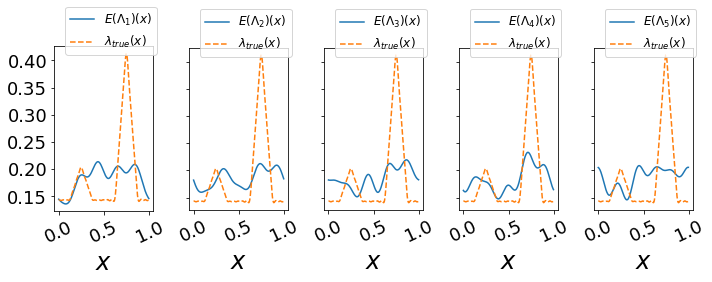

In [15]:
%run examples/clustering.py